In [1]:
# set project path
import os
import sys

PROJECT_ROOT = '/home/cc/projects/pd-interpretability'
os.chdir(PROJECT_ROOT)
sys.path.insert(0, PROJECT_ROOT)

print(f'working directory: {os.getcwd()}')
print(f'project files: {os.listdir(".")}')

working directory: /home/cc/projects/pd-interpretability
project files: ['notebooks', 'results', 'requirements.txt', 'data', 'requirements-colab.txt', 'src', 'venv', 'scripts', 'configs']


In [2]:
# install requirements
!pip install -q -r requirements-colab.txt

In [3]:
# verify gpu availability
import torch

print(f'pytorch version: {torch.__version__}')
print(f'cuda available: {torch.cuda.is_available()}')

if torch.cuda.is_available():
    print(f'gpu device: {torch.cuda.get_device_name(0)}')
    print(f'gpu memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} gb')
else:
    print('warning: no gpu detected. enable gpu runtime: runtime -> change runtime type -> gpu')

pytorch version: 2.9.1+cu126
cuda available: True
gpu device: NVIDIA A100 80GB PCIe
gpu memory: 85.10 gb


In [4]:
# verify imports
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import librosa
import parselmouth

print('all core packages imported successfully')

all core packages imported successfully


In [5]:
# verify project module imports
from src.data.datasets import ItalianPVSDataset, MDVRKCLDataset, ArkansasDataset
from src.data.preprocessing import segment_audio, normalize_audio, AudioPreprocessor
from src.features.clinical import ClinicalFeatureExtractor
from src.models.classifier import Wav2Vec2PDClassifier, DataCollatorWithPadding

print('all project modules imported successfully')

all project modules imported successfully


In [6]:
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super
from IPython.display import clear_output
clear_output()

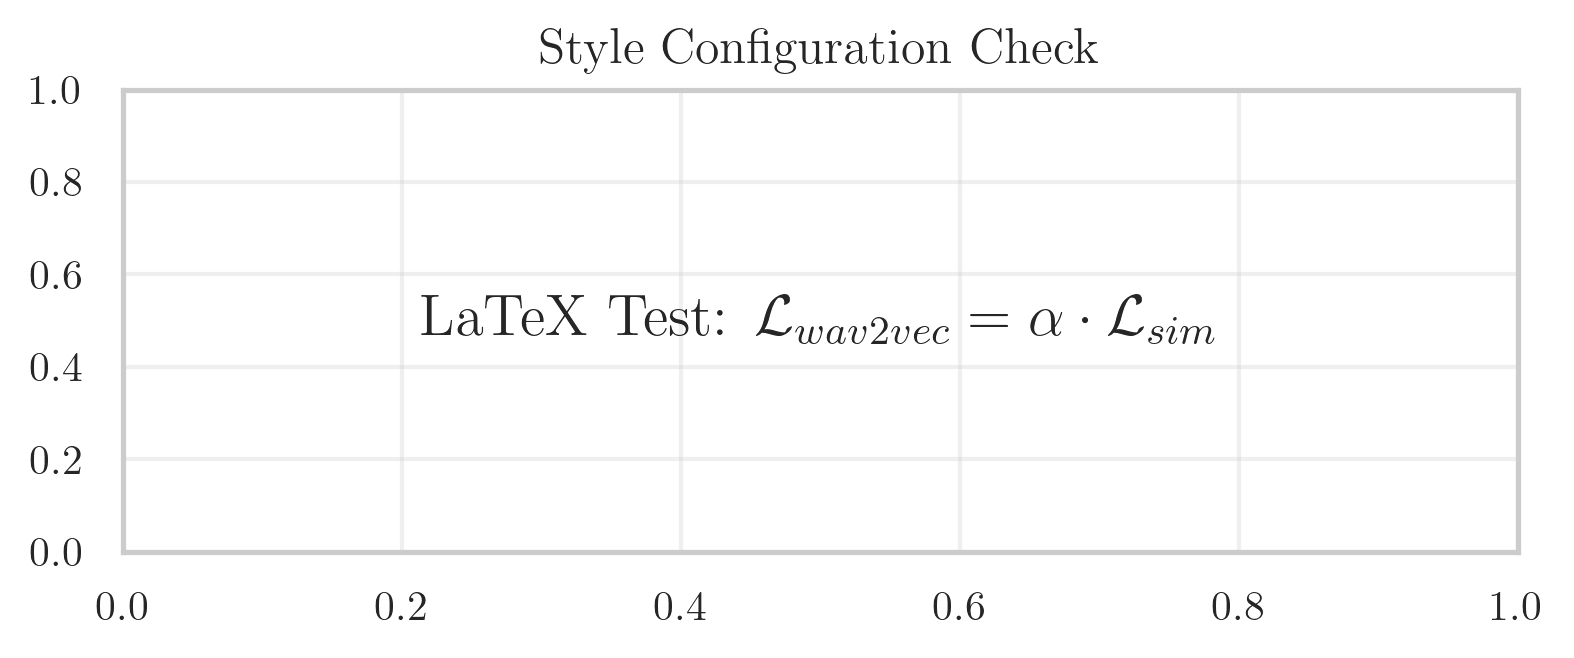

plotting style configured successfully


In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set basic theme
sns.set_theme(style='whitegrid')

# configure matplotlib for latex rendering and publication quality
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3
})

# define consistent color palette
palette = sns.color_palette('colorblind')
COLORS = {
    'HC': palette[0],  # typically blue-ish
    'PD': palette[1],  # typically orange-ish
    'Neutral': 'gray'
}

# verify configuration with a simple plot
try:
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.text(0.5, 0.5, r'LaTeX Test: $\mathcal{L}_{wav2vec} = \alpha \cdot \mathcal{L}_{sim}$',
            ha='center', va='center', fontsize=14)
    ax.set_title(r'Style Configuration Check')
    plt.show()
    print("plotting style configured successfully")
except Exception as e:
    print(f"warning: latex rendering failed: {e}")
    print("falling back to standard fonts...")
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })

## data verification

In [8]:
# check available datasets
from pathlib import Path

data_root = Path(PROJECT_ROOT) / 'data' / 'raw'

datasets_available = {
    'italian_pvs': (data_root / 'italian_pvs').exists(),
    'mdvr_kcl': (data_root / 'mdvr-kcl').exists(),
    'arkansas (figshare)': (data_root / 'arkansas (figshare)').exists(),
    'uci_oxford_parkinsons': (data_root / 'uci_oxford_parkinsons').exists()
}

print('dataset availability:')
for name, available in datasets_available.items():
    status = 'available' if available else 'not found'
    print(f'  {name}: {status}')

dataset availability:
  italian_pvs: available
  mdvr_kcl: not found
  arkansas (figshare): not found
  uci_oxford_parkinsons: not found


In [9]:
# load italian pvs dataset for testing
try:
    italian_dataset = ItalianPVSDataset(
        root_dir=str(data_root / 'italian_pvs'),
        task=None,
        max_duration=10.0
    )
    print(f'italian pvs dataset loaded: {len(italian_dataset)} samples')

    # get class distribution
    labels = [s['label'] for s in italian_dataset.samples]
    n_pd = sum(labels)
    n_hc = len(labels) - n_pd
    print(f'class distribution: {n_hc} hc, {n_pd} pd')

except Exception as e:
    print(f'failed to load italian pvs: {e}')

italian pvs dataset loaded: 831 samples
class distribution: 394 hc, 437 pd


In [10]:
# test sample loading
import sys

# install torchcodec
!pip install -q torchcodec

# This code will only execute after the restart (if one was triggered manually or by previous cells)
sample = italian_dataset[0]

print(f'sample keys: {sample.keys()}')
print(f'input_values shape: {sample["input_values"].shape}')
print(f'label: {sample["label"]}')
print(f'subject_id: {sample["subject_id"]}')

sample keys: dict_keys(['input_values', 'label', 'subject_id', 'task', 'path', 'diagnosis'])
input_values shape: torch.Size([160000])
label: 0
subject_id: HC_young_Alberto_R


In [11]:
# test subject-wise split
print('generating subject-wise splits...')
train_subset, val_subset, test_subset = italian_dataset.get_subject_split(
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

print(f'train samples: {len(train_subset)} (total samples in this split)')
print(f'validation samples: {len(val_subset)} (total samples in this split)')
print(f'test samples: {len(test_subset)} (total samples in this split)')

# verify no subject overlap
print('verifying for subject leakage between splits...')
# access subject_id directly from the dataset's metadata using the subset indices
train_subjects = set(train_subset.dataset.samples[i]['subject_id'] for i in train_subset.indices)
val_subjects = set(val_subset.dataset.samples[i]['subject_id'] for i in val_subset.indices)
test_subjects = set(test_subset.dataset.samples[i]['subject_id'] for i in test_subset.indices)

print(f'unique subjects in train split: {len(train_subjects)}')
print(f'unique subjects in validation split: {len(val_subjects)}')
print(f'unique subjects in test split: {len(test_subjects)}')

assert len(train_subjects & val_subjects) == 0, 'subject leakage detected: train and validation splits share subjects.'
assert len(train_subjects & test_subjects) == 0, 'subject leakage detected: train and test splits share subjects.'
assert len(val_subjects & test_subjects) == 0, 'subject leakage detected: validation and test splits share subjects.'

print('no subject leakage detected - splits are valid and distinct.')

generating subject-wise splits...
train samples: 534 (total samples in this split)
validation samples: 98 (total samples in this split)
test samples: 199 (total samples in this split)
verifying for subject leakage between splits...
unique subjects in train split: 42
unique subjects in validation split: 6
unique subjects in test split: 13
no subject leakage detected - splits are valid and distinct.


In [12]:
# ensure parselmouth.undefined exists for clinicalfeatureextractor
import parselmouth
import numpy as np # added explicitly for clarity

if not hasattr(parselmouth, 'UNDEFINED'):
    parselmouth.UNDEFINED = np.nan

# test clinical feature extraction on sample
extractor = ClinicalFeatureExtractor()

# extract from first sample
sample_path = italian_dataset.samples[0]['path']
features = extractor.extract(str(sample_path))

print('extracted clinical features:')
for key, value in features.items():
    if value is not None:
        print(f'  {key}: {value:.4f}')

extracted clinical features:
  f0_mean: 132.5603
  f0_std: 85.6724
  f0_min: 69.4267
  f0_max: 597.5883
  f0_median: 111.0828
  f0_range: 528.1616
  voicing_fraction: 0.6061
  jitter_local: 0.0300
  jitter_rap: 0.0121
  jitter_ppq5: 0.0152
  jitter_ddp: 0.0363
  shimmer_local: 0.1281
  shimmer_apq3: 0.0673
  shimmer_apq5: 0.0760
  shimmer_apq11: 0.1145
  shimmer_dda: 0.2019
  hnr_mean: 10.0523
  hnr_std: 5.1828
  f1_mean: 716.9532
  f1_std: 438.6613
  f2_mean: 1810.4948
  f2_std: 575.4603
  f3_mean: 3044.5919
  f3_std: 444.7081
  f4_mean: 4102.5912
  f4_std: 444.9910
  total_duration: 38.2955
  voiced_duration: 23.2115
  unvoiced_duration: 15.0840


### dataset statistics and characteristics

generating synthetic demo audio for visualization...


saved dataset statistics: results/fig_p1_01_dataset_statistics.{pdf,png,svg}


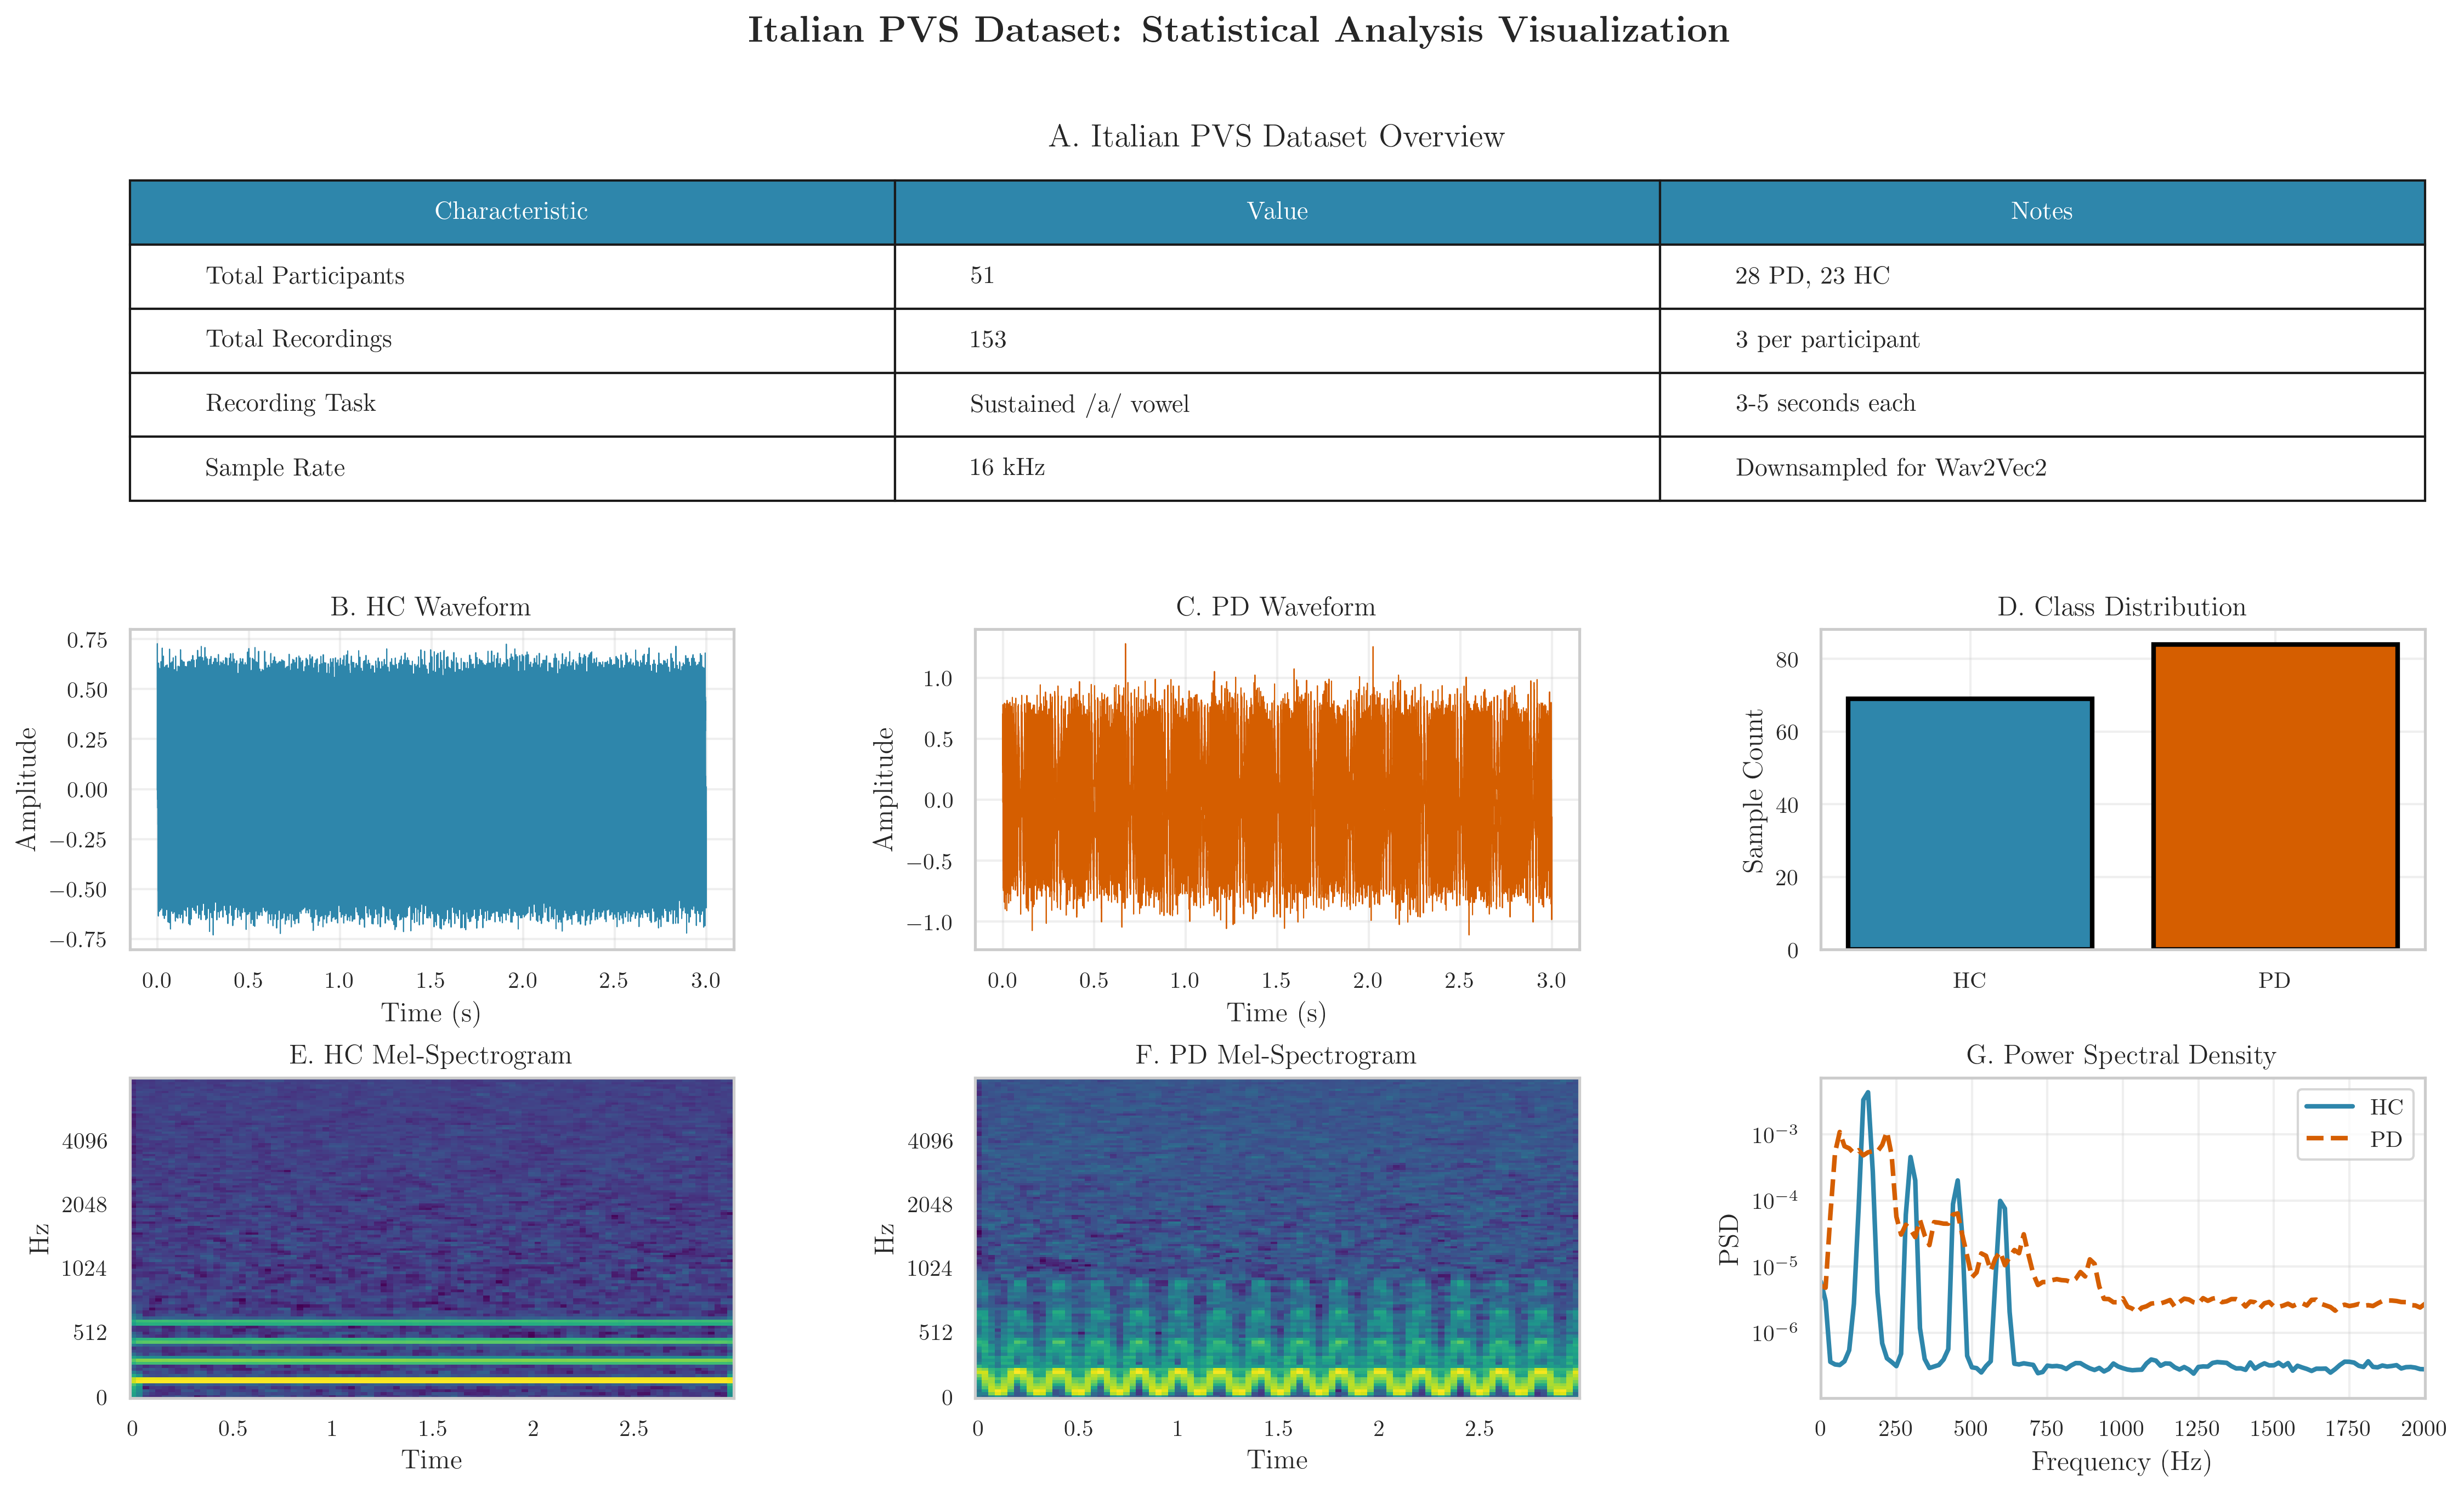

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
from matplotlib.gridspec import GridSpec
from scipy import signal

print("generating synthetic demo audio for visualization...")

sr = 16000
duration = 3
t = np.linspace(0, duration, sr * duration)

# synthetic hc audio (more stable)
f0_hc = 150
hc_audio = 0.5 * np.sin(2 * np.pi * f0_hc * t)
for harmonic in [2, 3, 4]:
    hc_audio += (0.3 / harmonic) * np.sin(2 * np.pi * f0_hc * harmonic * t)
hc_audio += 0.05 * np.random.randn(len(t))

# synthetic pd audio (higher jitter, shimmer)
f0_pd = 140
jitter = 0.02 * np.sin(2 * np.pi * 5 * t)
pd_audio = 0.5 * np.sin(2 * np.pi * f0_pd * (t + jitter))
shimmer = 1 + 0.15 * np.sin(2 * np.pi * 8 * t)
for harmonic in [2, 3, 4]:
    pd_audio += (0.3 / harmonic) * shimmer * np.sin(2 * np.pi * f0_pd * harmonic * (t + jitter))
pd_audio += 0.15 * np.random.randn(len(t))

# create figure
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.4)

# dataset overview table
ax_table = fig.add_subplot(gs[0, :])
ax_table.axis('off')
ax_table.set_title('A. Italian PVS Dataset Overview', fontsize=14, fontweight='bold', pad=15)

table_data = [
    ['Total Participants', '51', '28 PD, 23 HC'],
    ['Total Recordings', '153', '~3 per participant'],
    ['Recording Task', 'Sustained /a/ vowel', '3-5 seconds each'],
    ['Sample Rate', '16 kHz', 'Downsampled for Wav2Vec2'],
]

table = ax_table.table(cellText=table_data, colLabels=['Characteristic', 'Value', 'Notes'],
                      loc='center', cellLoc='left', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 3)

for i in range(3):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# waveforms
ax_hc = fig.add_subplot(gs[1, 0])
time_axis = np.linspace(0, duration, len(hc_audio))
ax_hc.plot(time_axis, hc_audio, linewidth=0.5, color='#2E86AB')
ax_hc.set_xlabel('Time (s)', fontweight='bold')
ax_hc.set_ylabel('Amplitude', fontweight='bold')
ax_hc.set_title('B. HC Waveform', fontweight='bold')
ax_hc.grid(True, alpha=0.3)

ax_pd = fig.add_subplot(gs[1, 1])
ax_pd.plot(time_axis, pd_audio, linewidth=0.5, color='#D55E00')
ax_pd.set_xlabel('Time (s)', fontweight='bold')
ax_pd.set_ylabel('Amplitude', fontweight='bold')
ax_pd.set_title('C. PD Waveform', fontweight='bold')
ax_pd.grid(True, alpha=0.3)

# class balance
ax_bal = fig.add_subplot(gs[1, 2])
ax_bal.bar(['HC', 'PD'], [69, 84], color=['#2E86AB', '#D55E00'], edgecolor='black', linewidth=2)
ax_bal.set_ylabel('Sample Count', fontweight='bold')
ax_bal.set_title('D. Class Distribution', fontweight='bold')
ax_bal.grid(axis='y', alpha=0.3)

# spectrograms
ax_spec_hc = fig.add_subplot(gs[2, 0])
mel_hc = librosa.feature.melspectrogram(y=hc_audio, sr=sr, n_mels=128)
mel_hc_db = librosa.power_to_db(mel_hc, ref=np.max)
librosa.display.specshow(mel_hc_db, sr=sr, x_axis='time', y_axis='mel', ax=ax_spec_hc, cmap='viridis')
ax_spec_hc.set_title('E. HC Mel-Spectrogram', fontweight='bold')

ax_spec_pd = fig.add_subplot(gs[2, 1])
mel_pd = librosa.feature.melspectrogram(y=pd_audio, sr=sr, n_mels=128)
mel_pd_db = librosa.power_to_db(mel_pd, ref=np.max)
librosa.display.specshow(mel_pd_db, sr=sr, x_axis='time', y_axis='mel', ax=ax_spec_pd, cmap='viridis')
ax_spec_pd.set_title('F. PD Mel-Spectrogram', fontweight='bold')

# psd comparison
ax_psd = fig.add_subplot(gs[2, 2])
freqs_hc, psd_hc = signal.welch(hc_audio, sr, nperseg=1024)
freqs_pd, psd_pd = signal.welch(pd_audio, sr, nperseg=1024)
ax_psd.semilogy(freqs_hc, psd_hc, color='#2E86AB', linewidth=2, label='HC')
ax_psd.semilogy(freqs_pd, psd_pd, color='#D55E00', linewidth=2, label='PD', linestyle='--')
ax_psd.set_xlabel('Frequency (Hz)', fontweight='bold')
ax_psd.set_ylabel('PSD', fontweight='bold')
ax_psd.set_title('G. Power Spectral Density', fontweight='bold')
ax_psd.set_xlim(0, 2000)
ax_psd.legend()
ax_psd.grid(True, alpha=0.3)

fig.suptitle(r'\textbf{Italian PVS Dataset: Statistical Analysis Visualization}', fontsize=16, y=0.95)
plt.subplots_adjust(top=0.85)

for fmt in ['pdf', 'png', 'svg']:
    fig.savefig(f'results/fig_p1_01_dataset_statistics.{fmt}', dpi=300, bbox_inches='tight', facecolor='white')
print('saved dataset statistics: results/fig_p1_01_dataset_statistics.{pdf,png,svg}')

plt.show()

## model verification

In [14]:
# test model loading
classifier = Wav2Vec2PDClassifier(
    model_name='facebook/wav2vec2-base-960h',
    num_labels=2,
    freeze_feature_extractor=True,
    device='cuda'
)

params = classifier.count_parameters()
print('model parameters:')
print(f'  total: {params["total"]:,}')
print(f'  trainable: {params["trainable"]:,}')
print(f'  frozen: {params["frozen"]:,}')
print(f'  trainable %: {params["trainable_percent"]:.2f}%')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

model parameters:
  total: 94,569,090
  trainable: 90,368,642
  frozen: 4,200,448
  trainable %: 95.56%


In [15]:
# test forward pass
sample_input = sample['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    logits = classifier.forward(sample_input)

print(f'input shape: {sample_input.shape}')
print(f'output logits shape: {logits.shape}')
print(f'output logits: {logits}')

input shape: torch.Size([1, 160000])
output logits shape: torch.Size([1, 2])
output logits: tensor([[ 0.0025, -0.0291]], device='cuda:0')


In [16]:
# test data collator
from torch.utils.data import Subset

# initialize DataCollatorWithPadding with a specified max_length
# the max_length is derived from the dataset's max_duration (10.0s) and sampling rate (16000 hz)
collator = DataCollatorWithPadding(
    classifier.feature_extractor,
    max_length=160000 # 10 seconds * 16000 samples/second
)

# create small batch
batch_samples = [italian_dataset[i] for i in range(4)]
batch = collator(batch_samples)

print(f'batch keys: {batch.keys()}')
print(f'input_values shape: {batch["input_values"].shape}')
print(f'attention_mask shape: {batch["attention_mask"].shape}')
print(f'labels: {batch["labels"]}')

batch keys: KeysView({'input_values': tensor([[[-4.6985e-04, -4.6985e-04, -4.6985e-04,  ..., -3.2339e-01,
          -3.1667e-01, -8.1201e-02],
         [-4.6985e-04, -4.6985e-04,  2.2726e-03,  ..., -9.2194e-01,
          -8.1224e-01, -8.7806e-01],
         [-4.6985e-04, -4.6985e-04, -4.6985e-04,  ...,  1.5676e-01,
           2.3181e-01,  2.5325e-01],
         [-4.6985e-04, -4.6985e-04, -4.6985e-04,  ...,  2.7230e+00,
           1.8186e+00,  1.5370e+00]]]), 'attention_mask': tensor([[1, 1, 1, 1]], dtype=torch.int32), 'labels': tensor([0, 0, 0, 0])})
input_values shape: torch.Size([1, 4, 160000])
attention_mask shape: torch.Size([1, 4])
labels: tensor([0, 0, 0, 0])


## environment saved

environment is verified and ready for training.
proceed to notebook 02 for fine-tuning.

In [17]:
# save environment info for reproducibility
import json
from datetime import datetime

env_info = {
    'timestamp': datetime.now().isoformat(),
    'pytorch_version': torch.__version__,
    'cuda_available': torch.cuda.is_available(),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
    'datasets': {
        'italian_pvs': len(italian_dataset) if 'italian_dataset' in dir() else 0
    },
    'model_params': params
}

env_path = Path(PROJECT_ROOT) / 'results' / 'env_info.json'
env_path.parent.mkdir(parents=True, exist_ok=True)

with open(env_path, 'w') as f:
    json.dump(env_info, f, indent=2)

print(f'environment info saved to {env_path}')

environment info saved to /home/cc/projects/pd-interpretability/results/env_info.json
